<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/5.1-LSTM-misclassification-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Miscategorized Reviews by LSTM

In previous notebooks, we filtered and trained LSTM network with 16 nodes based on original sample size of 1 million samples

Variations that we ran:

* 1-star and 5-star reviews only
* 1-star, 4-star, 5-star reviews only
* 1-star, 3-star, 4-star, 5-star reviews only
* All reviews

In this notebook, we will look at the model performance as well as look at specific reviews that were miscategorized

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 2.x selected.


''

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import json
from pprint import pprint


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set(font_scale=1.5)


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False


REPORT_FILE = f'{DRIVE_DIR}/reports/glove_embedding-dl_prototype-report.csv'




Read in report file

In [0]:
report = pd.read_csv(REPORT_FILE, quotechar="'")
report["train_examples"] = report.train_examples.astype(int)
# 1-star and 5-star only
lstm_15 = report[(report.model_name == "LSTMB16_15") & (report.train_examples == 505410)].copy().reset_index()
# 1-star, 4-star, and 5-star
lstm_145 = report[report.model_name == "LSTMB16_145"].copy().reset_index()
# 1-star, 3-star, 4-star, and 5-star
lstm_1345 = report[report.model_name == "LSTMB16_1345"].copy().reset_index()
# all reviews
lstm_all = report[(report.model_name == "LSTMB16") & (report.train_examples == 746766)].copy().reset_index()

data_file = lstm_15.file.values[0]

# Classification Report For Various Runs

Fix Classification Report so they display the proper categories

In [0]:
# map 2->5
cr15 = json.loads(lstm_15.classification_report.values[0])
cr15["5"] = cr15.pop("2")
lstm_15.loc[lstm_15.index, "classification_report"] = json.dumps(cr15)
lstm_15["label"] = "1,5 Star"

# map 3->5, 2->4
cr145 = json.loads(lstm_145.classification_report.values[0])
cr145["5"] = cr145.pop("3")
cr145["4"] = cr145.pop("2")
lstm_145.loc[lstm_145.index, "classification_report"] = json.dumps(cr145)
lstm_145["label"] = "1,4,5 Star"

# map 4->5, 3->4, 2->3
cr1345 = json.loads(lstm_1345.classification_report.values[0])
cr1345["5"] = cr1345.pop("4")
cr1345["4"] = cr1345.pop("3")
cr1345["3"] = cr1345.pop("2")
lstm_1345.loc[lstm_1345.index, "classification_report"] = json.dumps(cr1345)
lstm_1345["label"] = "1,3,4,5 Star"

lstm_all["label"] = "All"

In [0]:
report_all = pd.DataFrame()
report_all = report_all.append(lstm_15)
report_all = report_all.append(lstm_145)
report_all = report_all.append(lstm_1345)
report_all = report_all.append(lstm_all)
report_all = ru.convert_dnn_report_format(report_all)

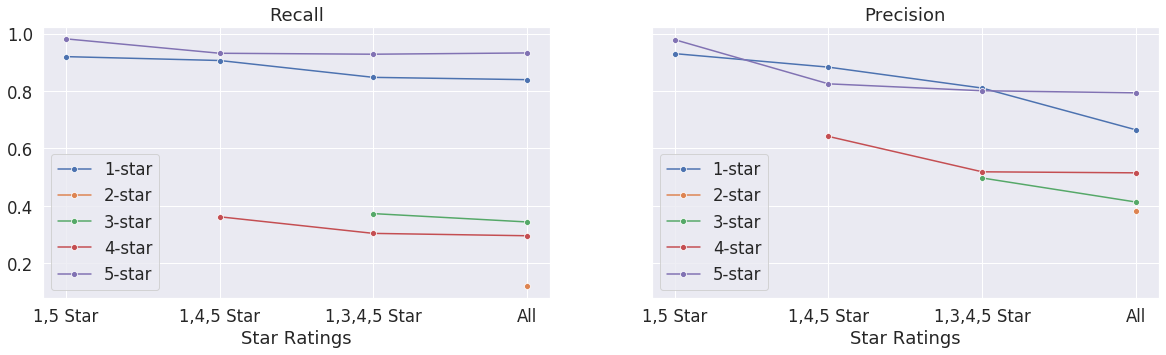

In [6]:
f, a = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
sns.lineplot(report_all.label, report_all["1_recall"], sort=False, label="1-star", marker="o", ax=a[0])
sns.lineplot(report_all.label, report_all["2_recall"], sort=False, label="2-star", marker="o", ax=a[0])
sns.lineplot(report_all.label, report_all["3_recall"], sort=False, label="3-star", marker="o", ax=a[0])
sns.lineplot(report_all.label, report_all["4_recall"], sort=False, label="4-star", marker="o", ax=a[0])
sns.lineplot(report_all.label, report_all["5_recall"], sort=False, label="5-star", marker="o", ax=a[0])
_ = a[0].set_xlabel("Star Ratings")
_ = a[0].set_ylabel("")
_ = a[0].set_title("Recall")

sns.lineplot(report_all.label, report_all["1_precision"], sort=False, label="1-star", marker="o", ax=a[1])
sns.lineplot(report_all.label, report_all["2_precision"], sort=False, label="2-star", marker="o", ax=a[1])
sns.lineplot(report_all.label, report_all["3_precision"], sort=False, label="3-star", marker="o", ax=a[1])
sns.lineplot(report_all.label, report_all["4_precision"], sort=False, label="4-star", marker="o", ax=a[1])
sns.lineplot(report_all.label, report_all["5_precision"], sort=False, label="5-star", marker="o", ax=a[1])
_ = a[1].set_xlabel("Star Ratings")
_ = a[1].set_ylabel("")
_ = a[1].set_title("Precision")

# Confusion Matrix For Various Runs

## 1-star and 5-star Only

In [7]:
pd.DataFrame(json.loads(lstm_15.confusion_matrix.values[0])).rename({0: 1, 1: 5}, axis=1)

,1,5
0,32248,2805
1,2411,131007


## 1-star, 4-star, 5-star

* 1-star most likely misclassified as 5-star
* 4-star most likely misclassified as 5-star
* 5-star most likely misclassified as 4-star

In [8]:
pd.DataFrame(json.loads(lstm_145.confusion_matrix.values[0])).rename({0: 1, 2: 5, 1: 4}, axis=1)

,1,4,5
0,31768,1322,1956
1,2152,15030,24372
2,2042,7064,124247


## 1-star, 3-star, 4-star, 5-star

* 1-star most likely misclassified as 3-star
* <font color="red">3-star most likely misclassified as 4-star (but 1 and 5 are pretty close)</font>
* 4-star most likely misclassified as 5-star
* 5-star most likely misclassified as 4-star

In [9]:
pd.DataFrame(json.loads(lstm_1345.confusion_matrix.values[0])).rename({0: 1, 1: 3, 2: 4, 3: 5}, axis=1)

,1,3,4,5
0,29828,2752,471,2135
1,4375,8373,4651,5061
2,1241,4137,12623,23539
3,1360,1585,6600,123745


## All star ratings

* 1-star most likely misclassified as 3-star
* <font color="red">2-star most likely misclassified as 1-star, 2-star is more likely to be misclassified as 1-star than itself</font>
* <font color="red">3-star most likley misclassified as 5-star, then 4-star and 1-star</font>
* 4-star most likely misclassified as 5-star
* 5-star most likely misclassified as 4-star

In [10]:
pd.DataFrame(json.loads(lstm_all.confusion_matrix.values[0])).rename({0: 1, 1: 2, 2: 3, 3: 4, 4: 5}, axis=1)

,1,2,3,4,5
0,29525,1480,1969,398,1791
1,8086,1991,3933,837,1651
2,4024,1369,7685,4346,4935
3,1236,248,3622,12214,23995
4,1534,123,1389,5925,124616
